# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [1]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [3]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [4]:
print df.shape, df.is_blocked.mean()
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [5]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.228222107326
Count: 1204949


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [6]:
#downsample
import random

unlegal_df, legal_df = df.loc[df['is_blocked'] == 1], df.loc[df['is_blocked'] == 0]
legal_df = legal_df.ix[random.sample(legal_df.index.values, len(unlegal_df))]

df = pd.concat([legal_df, unlegal_df])

print "Blocked ratio:",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio: 0.5
Count: 549992


In [7]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


In [8]:
#In case your RAM-o-meter is in the red
if very_low_RAM:
    data = data[::2]

# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [8]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


In [224]:
i = 0
j = 10
for k in token_counts:
    if i > j:
        print k, token_counts[k]
    i += 1
    if i > 50:
        break

woods 1
пастельное 1
стартером 7
прoхождение 1
соm 1
гостинная 74
манеры 2
диафрагма2 1
подстёжкой 5
кусочки 3
cp180 1
шлакоблок 8
новокубанске 1
кноп 1
иcключительно 1
переплетены 1
diver 1
осветление 2
mp180 1
прищепках 1
юркая 1
производителей 150
слышимость 2
семейному 1
производителем 9
со2 8
трибека 1
облаг 1
влагозащищены 1
ожегов 1
двухкомнатнаяулучшенка 1
полиспаст 1
опциями 3
славянская 16
флинт 1
lamide 1
мобильником 1
ландех 1
манера 2
понда 1


In [225]:
dir(token_counts)

['__add__',
 '__and__',
 '__class__',
 '__cmp__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__missing__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 'clear',
 'copy',
 'elements',
 'fromkeys',
 'get',
 'has_key',
 'items',
 'iteritems',
 'iterkeys',
 'itervalues',
 'keys',
 'most_common',
 'pop',
 'popitem',
 'setdefault',
 'subtract',
 'update',
 'values',
 'viewitems',
 'viewkeys',
 'viewvalues']

### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

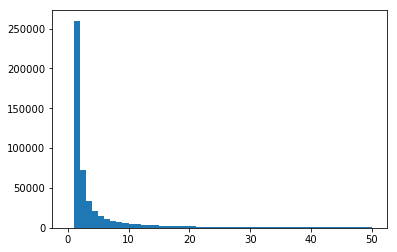

In [9]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [10]:
type(token_counts)

collections.Counter

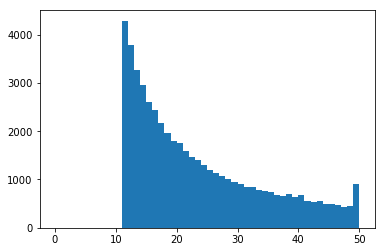

In [11]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10

tokens = Counter({k:token_counts[k] for k in token_counts if token_counts[k] > 10})
_=plt.hist(tokens.values(),range=[0,50],bins=50)

In [12]:
token_to_id = {t: i + 1 for i, t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [13]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you know what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 82892


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [14]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [15]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [16]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
DLS R6A -> [30651     0     0     0     0     0     0     0     0     0] ...
Компьютерная мышь- Genius M/NNetScroll 110 Made in -> [44215 76382 82619 67415     0 41150 30870 13037     0     0] ...
Отдам пианино -> [75495 25668     0     0     0     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [17]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [18]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

categories = [{"category":a[0], "subcategory":a[1]} for a in data_cat_subcat]
print categories[0]
#    A list of dictionaries {"category":category_name, "subcategory":subcategory_name} for each data sample]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

{'category': '\xd0\xa2\xd1\x80\xd0\xb0\xd0\xbd\xd1\x81\xd0\xbf\xd0\xbe\xd1\x80\xd1\x82', 'subcategory': '\xd0\x97\xd0\xb0\xd0\xbf\xd1\x87\xd0\xb0\xd1\x81\xd1\x82\xd0\xb8 \xd0\xb8 \xd0\xb0\xd0\xba\xd1\x81\xd0\xb5\xd1\x81\xd1\x81\xd1\x83\xd0\xb0\xd1\x80\xd1\x8b'}


In [19]:
print len(cat_one_hot)
cat_one_hot.head()

549992


,category=Бытовая электроника,category=Для бизнеса,category=Для дома и дачи,category=Животные,category=Личные вещи,category=Недвижимость,category=Работа,category=Транспорт,category=Услуги,category=Хобби и отдых,...,subcategory=Резюме,subcategory=Ремонт и строительство,subcategory=Собаки,subcategory=Спорт и отдых,subcategory=Телефоны,subcategory=Товары для детей и игрушки,subcategory=Товары для животных,subcategory=Товары для компьютера,subcategory=Фототехника,subcategory=Часы и украшения
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]
print len(cat_one_hot)
print df_non_text.phones_cnt.mean()
df_non_text.head()

549992
0.131691006415


,phones_cnt,emails_cnt,urls_cnt,price,category=Бытовая электроника,category=Для бизнеса,category=Для дома и дачи,category=Животные,category=Личные вещи,category=Недвижимость,...,subcategory=Резюме,subcategory=Ремонт и строительство,subcategory=Собаки,subcategory=Спорт и отдых,subcategory=Телефоны,subcategory=Товары для детей и игрушки,subcategory=Товары для животных,subcategory=Товары для компьютера,subcategory=Фототехника,subcategory=Часы и украшения
0,0,0,0,3500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,50,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,720000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,2787000,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Split data into training and test

In [21]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [ ]:
#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

alpha = 0.05
size = len(target)
tr_size = int(size * (1 - alpha))
ts_size = size - tr_size
print tr_size, ts_size
ts_ind = sorted(random.sample(range(size), ts_size))
tr_ind = [i for i in range(size) if i not in ts_ind]

title_tr, title_ts, desc_tr, desc_ts, nontext_tr, nontext_ts, target_tr, target_ts = \
    title_tokens[tr_ind], title_tokens[ts_ind], \
    desc_tokens[tr_ind], desc_tokens[ts_ind], \
    df_non_text.values[tr_ind], df_non_text.values[ts_ind], \
    target[tr_ind], target[ts_ind]


## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [25]:
save_prepared_data = True #save
read_prepared_data = False #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    data_tuple = (title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts)
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "done"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"        

Saving preprocessed data (may take up to 3 minutes)
done


In [26]:
print target_tr.mean()
print target_ts.mean()

0.499911960375
0.501672727273


# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [28]:
#libraries
import lasagne
from theano import tensor as T
import theano

In [127]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [128]:
from lasagne.init import Constant, Normal
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),
                                      input_var=title_token_ids
                                     )
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),
                                      input_var=desc_token_ids
                                     )
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]),
                                    input_var=categories
                                   )

In [129]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
number_of_units = 64
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, 
                                         input_size=len(token_to_id) + 1, 
                                         output_size=64,
                                         W=Normal()
                                         )
descr_nn1 = lasagne.layers.LSTMLayer(descr_nn, num_units=64, 
                                    nonlinearity=lasagne.nonlinearities.sigmoid
                                   )
#descr_nn = lasagne.layers.RecurrentLayer(descr_nn,
#                                         num_units=64
#                                        )
descr_nn2 = lasagne.layers.SliceLayer(descr_nn1,  -1, axis=-1)
#RNN or LSTM over embedding, maybe several ones in a stack

# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp, 
                                         input_size=len(token_to_id) + 1, 
                                         output_size=8, 
                                         W=Normal(1., 1.)
                                        )
title_nn1 = lasagne.layers.LSTMLayer(title_nn, num_units=8, 
                                    nonlinearity=lasagne.nonlinearities.sigmoid
                                   )
title_nn2 = lasagne.layers.SliceLayer(title_nn1, -1, axis=-1)

# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp,
                                   1,
                                   W=Normal(1., 1.),
                                   #b=Normal(0., 1.)
                                  )

In [130]:
nn = lasagne.layers.concat([descr_nn2, title_nn2, cat_nn], axis=1)
#nn = descr_nn2
nn1 = lasagne.layers.DenseLayer(nn, 64,)
nn2 = lasagne.layers.DropoutLayer(nn1, p=0.3)
nn = lasagne.layers.DenseLayer(nn2, 1, nonlinearity=lasagne.nonlinearities.sigmoid)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [131]:
from lasagne.regularization import regularize_layer_params, l2, l1
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

#Simple NN prediction
prediction = lasagne.layers.get_output(nn)

#Hinge loss
# loss = lasagne.objectives.binary_hinge_loss(prediction,
#                                            target_y,
#                                            delta=-0.5,
#                                            log_odds=True
#                                           ).mean()

loss = lasagne.objectives.binary_crossentropy(prediction, target_y).mean()
l1_penalty = regularize_layer_params(descr_nn2, l1) * 0.0001
l1_penalty_title = regularize_layer_params(title_nn2, l1) * 0.0001
l1_penalty_cat = regularize_layer_params(cat_nn, l1) * 0.0001

loss = loss + l1_penalty + l1_penalty_title + l1_penalty_cat
#Weight optimization step
updates = lasagne.updates.adam(loss, 
                              weights, 
                              learning_rate=0.01
                             )

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [132]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)

#equivalent loss function
# det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,
#                                                target_y,
#                                                delta=-0.5,
#                                                log_odds=True
#                                               ).mean()
det_loss = lasagne.objectives.binary_crossentropy(det_prediction, target_y).mean()

### Coffee-lation

In [133]:
# from theano.compile.nanguardmode import NanGuardMode 
# from theano.compile.debugmode import DebugMode
#NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
train_fun = theano.function([desc_token_ids, title_token_ids, categories, target_y],
                            [loss, prediction],
                            updates=updates,
                           )
eval_fun = theano.function([desc_token_ids, title_token_ids, categories, target_y],
                           [det_loss,det_prediction]
                          )

In [ ]:
# from theano.compile.nanguardmode import NanGuardMode 
# from theano.compile.debugmode import DebugMode
#NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
train_fun = theano.function([desc_token_ids, target_y],
                            [loss, prediction],
                            updates=updates,
                           )
eval_fun = theano.function([desc_token_ids,target_y],
                           [det_loss,det_prediction]
                          )

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [134]:
#average precision at K

from oracle import APatK, score

# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [135]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 20

train_loss = []
train_acc = []
train_auc = []
train_apatk = []
val_loss = []
val_acc = []
val_auc = []
val_apatk = []

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        
        
        
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc, b_title, b_cat, b_y)
#         print loss
        
        b_loss += loss
        b_c +=1
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    if not np.isnan(loss):
        print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.5)
        print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
        print '\tap@k:',APatK(epoch_y_true, epoch_y_pred, K = int(len(epoch_y_pred)*0.025)+1)
    
    train_loss.append(b_loss/b_c)
    train_acc.append(accuracy_score(epoch_y_true,epoch_y_pred>0.5))
    train_auc.append(roc_auc_score(epoch_y_true,epoch_y_pred))
    train_apatk.append(APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
            
        loss,pred_probas = eval_fun(b_desc, b_title, b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    if not np.isnan(loss):
        print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.5)
        print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
        print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    val_loss.append(b_loss/b_c)
    val_acc.append(accuracy_score(epoch_y_true,epoch_y_pred>0.5))
    val_auc.append(roc_auc_score(epoch_y_true,epoch_y_pred))
    val_apatk.append(APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))

Train:
	loss: 0.676844943413
	acc: 0.58
	auc: 0.604834398437
	ap@k: 1.0
Val:
	loss: 0.65317897171
	acc: 0.63
	auc: 0.667525386765
	ap@k: 1.0
Train:
	loss: 0.650968429556
	acc: 0.607619047619
	auc: 0.645898091518
	ap@k: 1.0
Val:
	loss: 0.632540200012
	acc: 0.599047619048
	auc: 0.792590294109
	ap@k: 0.0
Train:
	loss: 0.565714788232
	acc: 0.655714285714
	auc: 0.814904622463
	ap@k: 0.0
Val:
	loss: 0.455832537152
	acc: 0.805714285714
	auc: 0.882957716968
	ap@k: 1.0
Train:
	loss: 0.426758386149
	acc: 0.837142857143
	auc: 0.888700971475
	ap@k: 0.0
Val:
	loss: 0.389411438412
	acc: 0.833333333333
	auc: 0.908585879204
	ap@k: 1.0
Train:
	loss: 0.373745550376
	acc: 0.84380952381
	auc: 0.911958781032
	ap@k: 1.0
Val:
	loss: 0.355960410503
	acc: 0.850952380952
	auc: 0.921192851959
	ap@k: 1.0
Train:
	loss: 0.366739617219
	acc: 0.857619047619
	auc: 0.919704121988
	ap@k: 0.0
Val:
	loss: 0.335825561118
	acc: 0.859047619048
	auc: 0.929947538444
	ap@k: 1.0
Train:
	loss: 0.325106525019
	acc: 0.874285714286


In [213]:
for i in range(240000):
    if target_tr[i] != 0:
        print target_tr[i]

In [211]:
print target_tr.mean()

0.499751192363


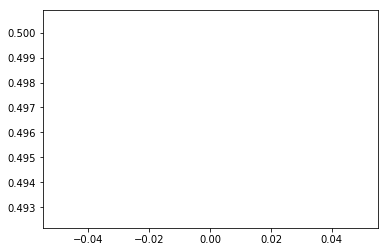

In [16]:
plt.plot(train_acc)
plt.plot(val_acc)

In [ ]:
plt.plot(train_auc)
plt.plot(val_auc)

In [ ]:
plt.plot(train_apatk)
plt.plot(val_apatk)

In [136]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. 


# Final evaluation
Evaluate network over the entire test set

In [147]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc, b_title, b_cat, b_y)

    b_loss += loss
    b_c +=1
    pred_probas = [1 if i else 0 for i in (pred_probas>0.5)]
    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0.5)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred>0.5,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.13003249585
	acc: 0.9516
	auc: 0.951532670112
	ap@k: 0.94440843167

AUC:
	Сойдёт, хотя можно ещё поднажать (ok)

Accuracy:
	Отличный результат! (good)

Average precision at K:
	Вы побили baseline (ok)


In [137]:
print epoch_y_true[:10]
print (epoch_y_pred>0.5)[:10] 

[0 1 1 1 0 1 1 1 1 1]
[[False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]]


In [145]:
a = [True, False, True]
1 if a[0] else 0
print np.array([1 if i else 0 for i in (epoch_y_pred>0.5)[:10]])
type (epoch_y_true)

[0 1 1 1 0 1 1 1 1 1]


numpy.ndarray

# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.